In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random

np.random.seed(1337)  # for reproducibility

def setGPU():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))
setGPU()

print('libs loaded')

Using TensorFlow backend.


libs loaded


In [2]:
# parameters
data_path = '../data/seg_data/{}/'
size = 128

def load_filenames(path):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    for f in filenames:
        if not '.npy' in f:
            del f
    training_filenames = []
    validation_filenames = []
    for f in filenames:
        if 'case1_' in f:
            validation_filenames.append(f)
        else:
            training_filenames.append(f)
            
            
    return training_filenames, validation_filenames
    
training_filenames, validation_filenames = load_filenames(data_path)

print(training_filenames)
print(validation_filenames)

['case10_label11.npy', 'case6_label11.npy', 'case8_label11.npy', 'case10_label6.npy', 'case9_label19.npy', 'case2_label13.npy', 'case9_label7.npy', 'case5_label3.npy', 'case6_label15.npy', 'case6_label8.npy', 'case10_label4.npy', 'case9_label13.npy', 'case3_label6.npy', 'case2_label5.npy', 'case9_label12.npy', 'case6_label9.npy', 'case9_label17.npy', 'case9_label10.npy', 'case8_label12.npy', 'case8_label4.npy', 'case4_label14.npy', 'case9_label5.npy', 'case4_label6.npy', 'case8_label5.npy', 'case5_label8.npy', 'case4_label3.npy', 'case8_label9.npy', 'case8_label18.npy', 'case8_label15.npy', 'case6_label19.npy', 'case8_label10.npy', 'case9_label8.npy', 'case4_label11.npy', 'case5_label17.npy', 'case4_label12.npy', 'case3_label16.npy', 'case2_label8.npy', 'case2_label7.npy', 'case8_label19.npy', 'case3_label7.npy', 'case8_label8.npy', 'case4_label19.npy', 'case3_label15.npy', 'case6_label6.npy', 'case5_label18.npy', 'case4_label15.npy', 'case5_label5.npy', 'case4_label4.npy', 'case5_labe

In [12]:

def model():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Dense, Flatten
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, 8)
    conv2 = conv(conv1, 8)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, 16)
    conv4 = conv(conv3, 16)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, 32)
    conv6 = conv(conv5, 32)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, 64)
    conv8 = conv(conv7, 64)

    pool4 = pool(conv8)
    
    conv9 = conv(pool4, 128)
    conv10 = conv(conv9, 128)
    
    flat = Flatten()(conv10)
    
    dense1 = Dense(units = 20, activation = 'relu')(flat)
    
    output_cat = Dense(units = 20, activation = 'softmax')(dense1)

    
    # model
    model = Model(inputs=input_img, outputs=output_cat)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-4)#32-5,16-3
    
    model.compile(optimizer=opt,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = model()

(None, 20)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 128, 1)  0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 128, 128, 128, 8)  224       
_________________________________________________________________
batch_normalization_21 (Batc (None, 128, 128, 128, 8)  32        
_________________________________________________________________
activation_21 (Activation)   (None, 128, 128, 128, 8)  0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 128, 128, 128, 8)  1736      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 128, 8)  32        
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 128, 8)  0         

In [13]:
import re

def generator(batch_size, filenames):
    while 1:
        shape = (batch_size, size, size, size, 1)
        shape2 = (batch_size, 20)
        
        x_out = np.zeros(shape)
        y_out2 = np.zeros(shape2)
        
        for i in range(batch_size):
            filename = random.choice(filenames)
            x = np.load(data_path.format('y') + filename)
            #print(filename)
            x = np.reshape(x, (size, size, size, -1))
            
            x_out[i] = x
            
            label = int(re.sub("\D", "", filename.split('.')[0].split('_')[1]))
            label_one_hot = [0] * 20
            label_one_hot[label] = 1
            
            y_out2[i] = label_one_hot
            #print(label_one_hot)
            
        yield (x_out, y_out2)

In [19]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0,
#                                mode='auto')
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./save/model.weights.best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min') 

history = model.fit_generator(  generator(8, training_filenames),
                                validation_data=generator(16, validation_filenames),
                                steps_per_epoch=10,
                                validation_steps = 10,
                                epochs=2000,
                                callbacks=[checkpoint])

Epoch 1/2000
10/10 [==============================] - 12s 1s/step - loss: 2.7083 - acc: 0.1000 - val_loss: 2.9870 - val_acc: 0.0938
Epoch 2/2000
10/10 [==============================] - 12s 1s/step - loss: 2.6376 - acc: 0.1250 - val_loss: 3.0063 - val_acc: 0.0250
Epoch 3/2000
10/10 [==============================] - 12s 1s/step - loss: 2.5368 - acc: 0.2125 - val_loss: 3.0059 - val_acc: 0.0625
Epoch 4/2000
10/10 [==============================] - 12s 1s/step - loss: 2.5617 - acc: 0.1500 - val_loss: 3.0074 - val_acc: 0.0437
Epoch 5/2000
10/10 [==============================] - 12s 1s/step - loss: 2.6416 - acc: 0.1875 - val_loss: 2.9952 - val_acc: 0.0500
Epoch 6/2000
10/10 [==============================] - 12s 1s/step - loss: 2.6596 - acc: 0.1250 - val_loss: 3.0046 - val_acc: 0.0437
Epoch 7/2000
10/10 [==============================] - 12s 1s/step - loss: 2.3682 - acc: 0.2125 - val_loss: 2.9840 - val_acc: 0.0625
Epoch 8/2000
10/10 [==============================] - 12s 1s/step - loss: 2.

10/10 [==============================] - 12s 1s/step - loss: 2.1506 - acc: 0.3750 - val_loss: 2.7331 - val_acc: 0.2562
Epoch 31/2000
10/10 [==============================] - 12s 1s/step - loss: 2.2504 - acc: 0.3250 - val_loss: 2.5740 - val_acc: 0.3187
Epoch 32/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0739 - acc: 0.4000 - val_loss: 2.5407 - val_acc: 0.3375
Epoch 33/2000
10/10 [==============================] - 12s 1s/step - loss: 2.1562 - acc: 0.3375 - val_loss: 2.4899 - val_acc: 0.3875
Epoch 34/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0482 - acc: 0.4000 - val_loss: 2.5986 - val_acc: 0.2000
Epoch 35/2000
10/10 [==============================] - 12s 1s/step - loss: 2.1325 - acc: 0.3500 - val_loss: 2.5401 - val_acc: 0.2687
Epoch 36/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0294 - acc: 0.3125 - val_loss: 2.4502 - val_acc: 0.3250
Epoch 37/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0188 -

10/10 [==============================] - 12s 1s/step - loss: 2.0994 - acc: 0.3250 - val_loss: 2.3574 - val_acc: 0.2687
Epoch 62/2000
10/10 [==============================] - 12s 1s/step - loss: 1.8603 - acc: 0.3500 - val_loss: 2.5743 - val_acc: 0.3000
Epoch 63/2000
10/10 [==============================] - 12s 1s/step - loss: 1.9784 - acc: 0.3750 - val_loss: 2.3913 - val_acc: 0.3000
Epoch 64/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0582 - acc: 0.3250 - val_loss: 2.4973 - val_acc: 0.3063
Epoch 65/2000
10/10 [==============================] - 12s 1s/step - loss: 1.7955 - acc: 0.3625 - val_loss: 2.5319 - val_acc: 0.3312
Epoch 66/2000
10/10 [==============================] - 12s 1s/step - loss: 1.6028 - acc: 0.4875 - val_loss: 2.4725 - val_acc: 0.3563
Epoch 67/2000
10/10 [==============================] - 12s 1s/step - loss: 1.7852 - acc: 0.4000 - val_loss: 2.5340 - val_acc: 0.3187
Epoch 68/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0811 -

Epoch 94/2000
10/10 [==============================] - 12s 1s/step - loss: 1.8117 - acc: 0.3750 - val_loss: 2.7248 - val_acc: 0.2625
Epoch 95/2000
10/10 [==============================] - 12s 1s/step - loss: 1.8278 - acc: 0.3625 - val_loss: 2.6772 - val_acc: 0.3500
Epoch 96/2000
10/10 [==============================] - 12s 1s/step - loss: 1.8274 - acc: 0.3125 - val_loss: 2.3508 - val_acc: 0.3000
Epoch 97/2000
10/10 [==============================] - 12s 1s/step - loss: 1.8616 - acc: 0.3500 - val_loss: 2.3419 - val_acc: 0.3187
Epoch 98/2000
10/10 [==============================] - 12s 1s/step - loss: 1.7921 - acc: 0.3375 - val_loss: 2.4890 - val_acc: 0.3250
Epoch 99/2000
10/10 [==============================] - 12s 1s/step - loss: 1.6861 - acc: 0.3500 - val_loss: 2.5551 - val_acc: 0.3063
Epoch 100/2000
10/10 [==============================] - 12s 1s/step - loss: 1.8286 - acc: 0.3500 - val_loss: 2.6477 - val_acc: 0.2375
Epoch 101/2000
10/10 [==============================] - 12s 1s/step 

Epoch 127/2000
10/10 [==============================] - 12s 1s/step - loss: 1.7679 - acc: 0.3625 - val_loss: 2.5477 - val_acc: 0.3250
Epoch 128/2000
10/10 [==============================] - 12s 1s/step - loss: 1.6619 - acc: 0.4250 - val_loss: 2.2670 - val_acc: 0.3250
Epoch 129/2000
10/10 [==============================] - 12s 1s/step - loss: 1.3923 - acc: 0.4375 - val_loss: 2.5867 - val_acc: 0.3500
Epoch 130/2000
10/10 [==============================] - 12s 1s/step - loss: 1.5589 - acc: 0.3625 - val_loss: 2.2873 - val_acc: 0.4062
Epoch 131/2000
10/10 [==============================] - 12s 1s/step - loss: 1.4132 - acc: 0.4375 - val_loss: 2.3606 - val_acc: 0.4188
Epoch 132/2000
10/10 [==============================] - 12s 1s/step - loss: 1.5219 - acc: 0.4625 - val_loss: 2.2708 - val_acc: 0.3125
Epoch 133/2000
10/10 [==============================] - 12s 1s/step - loss: 1.7060 - acc: 0.3125 - val_loss: 2.4231 - val_acc: 0.3438
Epoch 134/2000
10/10 [==============================] - 12s 1s

KeyboardInterrupt: 

In [ ]:
def plot_result():
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_result()

In [23]:

#model.save_weights('./save/model_weights.h5')

In [25]:
del model

case1_label9.npy


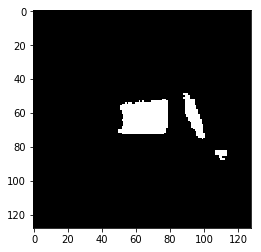

In [38]:
filename = validation_filenames[0]
print(filename)
x = np.load(data_path.format('y') + filename)
plt.imshow(x[:,:,65], cmap='gray')
x = np.reshape(x, (1, 128, 128, 128, -1))

In [39]:
y_cat = model.predict(x)
print(y_cat[0])
print(max(y_cat[0]))
print(np.argmax(y_cat))

[0.05600699 0.03173709 0.03822409 0.05903802 0.03061834 0.03771988
 0.0723184  0.07143686 0.03328035 0.06424842 0.03549782 0.03662397
 0.03973443 0.05227344 0.04826288 0.05150586 0.06920768 0.07430369
 0.06837983 0.02958193]
0.074303694
17


In [ ]:
y = np.load(data_path.format('y') + validation_filenames[0])
plt.imshow(y[:,:,65], cmap='gray')

In [40]:
model.save_weights('./save/model.label.weights.final.h5')
#model.load_weights('./save/model.weights.best.h5')

In [26]:
import random
import re

def generator(batch_size, filenames):
    size = 128
    
    shape = (batch_size, size, size, size, 1)

    x_out = np.zeros(shape)
    y_out = np.zeros(shape)

    for i in range(batch_size):
        filename = random.choice(filenames)
        #filename = filenames[0]
        x = np.load(data_path.format('x') + filename)
        y = np.load(data_path.format('y') + filename)
        x = np.reshape(x, (size, size, size, -1))
        y = np.reshape(y, (size, size, size, -1))

        x_out[i] = x
        y_out[i] = y
    
        print(filename.split('_')[0])
        print(int(re.sub("\D", "", filename.split('_')[0])))
        
        label = int(re.sub("\D", "", filename.split('_')[0]))
        y_out2 = [0] * 20
        y_out2[label] = 1
        print(y_out2)
        
generator(1, training_filenames)

case9
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
print(random.randint(-2,2))

1


In [25]:
    x_bias, y_bias, z_bias = random.randint(-2,2), random.randint(-2,2), random.randint(-2,2)
    x_range = (x_bias, 127) if x_bias > 0 else (0, size + x_bias -1)
    y_range = (y_bias, 127) if y_bias > 0 else (0, size + y_bias -1)
    z_range = (z_bias, 127) if z_bias > 0 else (0, size + z_bias -1)
    print(x_range)

(0, 125)
